
###### The problem statement is to develop a machine learning model that predicts the personality type of an individual based on their forum posts.

## Importing Library

In [1]:

import numpy as np 
import pandas as pd 
import os

import re
from bs4 import BeautifulSoup
import string
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
import nltk
nltk.download('stopwords')
nltk.download('wordnet')

from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import cross_validate
from sklearn.model_selection import StratifiedKFold
from sklearn.linear_model import LogisticRegression

In [2]:
train_data=pd.read_csv('mbti_1.csv')
forum_data=pd.read_csv('ForumMessages.csv')

In [3]:
train_data.head()

,type,posts
0,INFJ,'http://www.youtube.com/watch?v=qsXHcwe3krw|||...
1,ENTP,'I'm finding the lack of me in these posts ver...
2,INTP,'Good one _____ https://www.youtube.com/wat...
3,INTJ,"'Dear INTP, I enjoyed our conversation the o..."
4,ENTJ,'You're fired.|||That's another silly misconce...


In [4]:
train_data['posts'][0]

"'http://www.youtube.com/watch?v=qsXHcwe3krw|||http://41.media.tumblr.com/tumblr_lfouy03PMA1qa1rooo1_500.jpg|||enfp and intj moments  https://www.youtube.com/watch?v=iz7lE1g4XM4  sportscenter not top ten plays  https://www.youtube.com/watch?v=uCdfze1etec  pranks|||What has been the most life-changing experience in your life?|||http://www.youtube.com/watch?v=vXZeYwwRDw8   http://www.youtube.com/watch?v=u8ejam5DP3E  On repeat for most of today.|||May the PerC Experience immerse you.|||The last thing my INFJ friend posted on his facebook before committing suicide the next day. Rest in peace~   http://vimeo.com/22842206|||Hello ENFJ7. Sorry to hear of your distress. It's only natural for a relationship to not be perfection all the time in every moment of existence. Try to figure the hard times as times of growth, as...|||84389  84390  http://wallpaperpassion.com/upload/23700/friendship-boy-and-girl-wallpaper.jpg  http://assets.dornob.com/wp-content/uploads/2010/04/round-home-design.jpg ...

In [83]:
forum_data.head()

,Unnamed: 0,Id,ForumTopicId,PostUserId,PostDate,ReplyToForumMessageId,Message,Medal,MedalAwardDate
0,8427,784283,60581,4701687,03/24/2020 04:42:45,NaN,<p><strong>Think About The Data</strong></p>\n...,3.0,2019-08-03
1,9564,784295,60581,4701687,03/24/2020 04:56:27,783670.0,<p>good point!</p>,3.0,2019-08-03
2,9579,784298,60581,4701687,03/24/2020 05:02:18,781693.0,<p>Nice thoughts!</p>,3.0,2019-08-03
3,13138,784405,60581,4662825,03/24/2020 07:34:31,NaN,<p>All fields that has year data maxes up on 2...,3.0,2019-08-03
4,19987,787791,60581,3780256,03/27/2020 04:46:14,NaN,<p>The dataset reflects the real estate scenar...,3.0,2019-08-03


# Data Prepartion and Cleaning


In [6]:
mbti={'I':'Introversion','E':'Extroversion','N':'Intuition','S':'Sensing','T':'Thinking','F':'Feeling','J':'Judging','P':'Perceiving'}

In [7]:
train_data.shape

(8675, 2)

In [8]:
forum_data.shape

(2042, 9)

In [9]:
train_data['type'].nunique()

16

In [10]:
#Now looking at the personality distrubution in the training data
type_count=train_data['type'].value_counts()
print(type_count)

INFP    1832
INFJ    1470
INTP    1304
INTJ    1091
ENTP     685
ENFP     675
ISTP     337
ISFP     271
ENTJ     231
ISTJ     205
ENFJ     190
ISFJ     166
ESTP      89
ESFP      48
ESFJ      42
ESTJ      39
Name: type, dtype: int64


Personality types start descending from the top to bottom

### Looking for missing values in the data

In [11]:
print("Missing values in test data: ")
print(train_data.isnull().sum())

Missing values in test data: 
type     0
posts    0
dtype: int64


In [12]:
forum_data.head()

,Unnamed: 0,Id,ForumTopicId,PostUserId,PostDate,ReplyToForumMessageId,Message,Medal,MedalAwardDate
0,8427,784283,60581,4701687,03/24/2020 04:42:45,NaN,<p><strong>Think About The Data</strong></p>\n...,NaN,NaN
1,9564,784295,60581,4701687,03/24/2020 04:56:27,783670.0,<p>good point!</p>,NaN,NaN
2,9579,784298,60581,4701687,03/24/2020 05:02:18,781693.0,<p>Nice thoughts!</p>,NaN,NaN
3,13138,784405,60581,4662825,03/24/2020 07:34:31,NaN,<p>All fields that has year data maxes up on 2...,NaN,NaN
4,19987,787791,60581,3780256,03/27/2020 04:46:14,NaN,<p>The dataset reflects the real estate scenar...,NaN,NaN


In [13]:
print("Missing values in form data: ")
print(forum_data.isnull().sum())

Missing values in form data: 
Unnamed: 0                  0
Id                          0
ForumTopicId                0
PostUserId                  0
PostDate                    0
ReplyToForumMessageId    1040
Message                     4
Medal                    1735
MedalAwardDate           1731
dtype: int64


In [14]:
forum_data['Medal'].value_counts()

3.0    261
2.0     29
1.0     17
Name: Medal, dtype: int64

In [ ]:
1735/2042

#### Now, we will fill the missing values in th form data.

In [14]:
forum_data['Message']=forum_data['Message'].fillna('')
print("Missing values in form data: ")
print(forum_data.isnull().sum())

Missing values in form data: 
Unnamed: 0                  0
Id                          0
ForumTopicId                0
PostUserId                  0
PostDate                    0
ReplyToForumMessageId    1040
Message                     0
Medal                    1735
MedalAwardDate           1731
dtype: int64


In [17]:
forum_data['Medal'].fillna(forum_data['Medal'].median(), inplace=True)

In [23]:
forum_data['MedalAwardDate']=pd.to_datetime(forum_data['MedalAwardDate'])

In [26]:
# Get the mode of MedalAwardDate column
mode_medal_award_date =forum_data['MedalAwardDate'].mode()[0]

In [28]:
# Fill missing MedalAwardDate values with mode
forum_data['MedalAwardDate'].fillna(mode_medal_award_date, inplace=True)

In [29]:
print(forum_data.isnull().sum())

Unnamed: 0                  0
Id                          0
ForumTopicId                0
PostUserId                  0
PostDate                    0
ReplyToForumMessageId    1040
Message                     0
Medal                       0
MedalAwardDate              0
dtype: int64


Now, we will group the user by PostUserId since a particular user could have posted more than once.

In [30]:
forum_data_g=forum_data.groupby('PostUserId')['Message'].agg(lambda col: ' '.join(col)).reset_index()


In [31]:
print(forum_data_g['PostUserId'].value_counts())

9028       1
4746345    1
4771974    1
4770260    1
4767344    1
          ..
2902238    1
2900261    1
2894958    1
2891924    1
7152530    1
Name: PostUserId, Length: 1857, dtype: int64


In [19]:
train_data['posts'][10]

"'One time my parents were fighting over my dad's affair and my dad pushed my mom. The fall broke her finger.  She's pointed a gun at him and made him get on his knees and beg for his life. She's...|||I'm gonna talk about what a piece of shit my dad is now.  He's an alcoholic and he has some kind of serious mental problem when it comes to complying with the IRS. (In his words, Laws don't apply...|||OMG...at the women's center I lived at, run by a Catholic charity, the fat bully program manager took it upon herself to change policy so that tenants were FORCED to attend the Christmas party. If...|||I don't work, but I have a calling I am 100% committed to 24/7 with no vacation or off days EVER. I'm a Kundalini mystic.  Oh, I don't get paid, either!  It's one of those destined things...|||My art teacher in high school had a stack of art school catalogs. When I saw the one for the school I ended up going to, I immediately knew that was the one. Without any research. It was like when...|||I

In [18]:
train_data['posts'][2]

"'Good one  _____   https://www.youtube.com/watch?v=fHiGbolFFGw|||Of course, to which I say I know; that's my blessing and my curse.|||Does being absolutely positive that you and your best friend could be an amazing couple count? If so, than yes.   Or it's more I could be madly in love in case I reconciled my feelings (which at...|||No, I didn't; thank you for a link!|||So-called Ti-Si loop (and it can stem from any current topic/obsession) can be deadly. It's like when you're stuck in your own thoughts, and your mind just wanders in circles. Feels truly terrible. ...|||Have you noticed how peculiar vegetation can be? All you have to do is look down at the grass: dozens of different plant species there.    And now imagine that hundreds of years later (when/if soil...|||The Smiths – Never Had No One Ever|||I often find myself spotting faces on marble tiles/wood.|||This 5 year-old sentence is an incredibly accurate and beautiful description.|||I haven't visited this website in the last 3

### Data Cleaning

In [72]:
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\dell\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\dell\AppData\Roaming\nltk_data...


True

In [73]:
def text_cleaning(text):
    text=BeautifulSoup(text,'lxml').text
    #removing html and seperators
    text=re.sub(r'\|\|\|', r'  ', text)
    text=re.sub(r'http\S+', r'  ', text)
    ### Special character removal 
    #removing puntuations
    text=text.replace('.', '  ')
    translator=str.maketrans('', '', string.punctuation)
    text=text.translate(translator)
    #removing numbers
    text=''.join(i for i in text if not i.isdigit())
    # Remove stop words
    stop_words = stopwords.words('english')
    text = ' '.join([word for word in text.split() if word not in stop_words])
    # lemmitizaton
    lemmatizer = WordNetLemmatizer()
    text = ' '.join([lemmatizer.lemmatize(word) for word in text.split()])
    return text

In [74]:
train_data['clean_posts']=train_data['posts'].apply(text_cleaning)

C:\Users\dell\AppData\Local\Temp\ipykernel_11204\1435873697.py:2: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  text=BeautifulSoup(text,'lxml').text


In [75]:
train_data['clean_posts'][1]

'Im finding lack post alarming Sex boring position often For example girlfriend currently environment creatively use cowgirl missionary There isnt enough Giving new meaning Game theory Hello ENTP Grin Thats take Than converse flirting I acknowledge presence return word smooth wordplay cheeky grin This Lack Balance Hand Eye Coordination Real IQ test I score Internet IQ test funny I score higher Now like former response thread I mention I dont believe IQ test Before banish You know youre ENTP vanish site year half return find people still commenting post liking ideasthoughts You know youre ENTP I think thing sometimes I go old Sherlock Holmes quote Perhaps man special knowledge special power like rather encourages seek complex cheshirewolf tumblr com So I D post Not really Ive never thought EI JP real function I judge I use I use Ne Ti dominates Fe emotion rarely Si I also use Ni due strength You know though That ingenious After saying I really want try see happens playing first person s

In [76]:
forum_data_g['clean_messages']=forum_data_g['Message'].apply(text_cleaning)


In [77]:
forum_data_g['clean_messages'][1]

'Personally I wouldnt trust data skewed preeconomic crisis The reality real state pre crisis actual real state construction changed specially since availability credit setup moved people aquire specific good probably purchasing house In event model would become skewed scenario year meaning poorly fitted model future value specially inicial year event A longer run data would better take account evolution pricing'

In [44]:
## Highlight the bold words - CAPS

def split_uppercase(text):
    text_list = text.split()
    new_list = []
    for i in text_list:
        if i.isupper() == False: 
            word = re.sub(r'([A-Z])', r' \1', i)
            new_list.append(word)
        else:
            word = i
            new_list.append(word)
    words = ' '.join(new_list)
    return words

In [45]:
forum_data_g['clean_messages']=forum_data_g['clean_messages'].apply(split_uppercase)

In [46]:
forum_data_g['clean_messages'][1]

' Personally I wouldnt trust the data as it is skewed to a preeconomic crisis  The reality of the real state pre crisis and actual real state construction should have changed specially since the availability of credit in this setup moved people to aquire specific good most probably purchasing houses  In this event the model would become skewed to what the scenario in those years was meaning in a poorly fitted model for future values specially at the inicial years after the event A longer run of data would be better to take into account the evolution of pricing'

# Model Building

In [79]:
kfolds = StratifiedKFold(n_splits=5, shuffle=True, random_state=1)

scoring = {'acc': 'accuracy',
           'neg_log_loss': 'neg_log_loss',
           'f1_micro': 'f1_micro'}

In [80]:
countVect=CountVectorizer(ngram_range=(1,1), stop_words='english', lowercase=True, max_features=5000)
model=Pipeline([('countVect',countVect),('lr',LogisticRegression(class_weight='balanced',C=0.005))])
results=cross_validate(model, train_data['clean_posts'],train_data['type'], cv=kfolds, scoring=scoring, n_jobs=-1)

In [82]:
print("Accuracy: {:0.5f} ".format(np.mean(results['test_acc'])))
print("Logloss: {:0.5f} ".format(np.mean(-1*results['test_neg_log_loss'])))

Accuracy: 0.65602 
Logloss: 1.30822 


# Model Predictions

In [56]:
model.fit(train_data['clean_posts'],train_data['type'])

C:\Users\dell\miniconda3\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Pipeline(steps=[('countVect',
                 CountVectorizer(max_features=5000, stop_words='english')),
                ('lr', LogisticRegression(C=0.005, class_weight='balanced'))])

In [58]:
pred=model.predict(forum_data_g['clean_messages'])

In [59]:
count=np.unique(pred,return_counts=True)
count

(array(['ENFJ', 'ENFP', 'ENTJ', 'ENTP', 'ESFJ', 'ESFP', 'ESTJ', 'ESTP',
        'INFP', 'INTJ', 'INTP', 'ISFJ', 'ISFP', 'ISTJ', 'ISTP'],
       dtype=object),
 array([  1,   2,  34,  58,  28, 394,   1,  26,   3, 873,  16,  89,  37,
        112, 183], dtype=int64))

In [60]:
list_of_preds=list(zip(count[0],count[1]))
pred_df=pd.DataFrame(list_of_preds, columns=['Personality','Count'])
pred_df

,Personality,Count
0,ENFJ,1
1,ENFP,2
2,ENTJ,34
3,ENTP,58
4,ESFJ,28
5,ESFP,394
6,ESTJ,1
7,ESTP,26
8,INFP,3
9,INTJ,873


# Observations: Plotting a Bar Graph

In [61]:
#importing the libraries
import matplotlib.pyplot as plt
import seaborn as sns

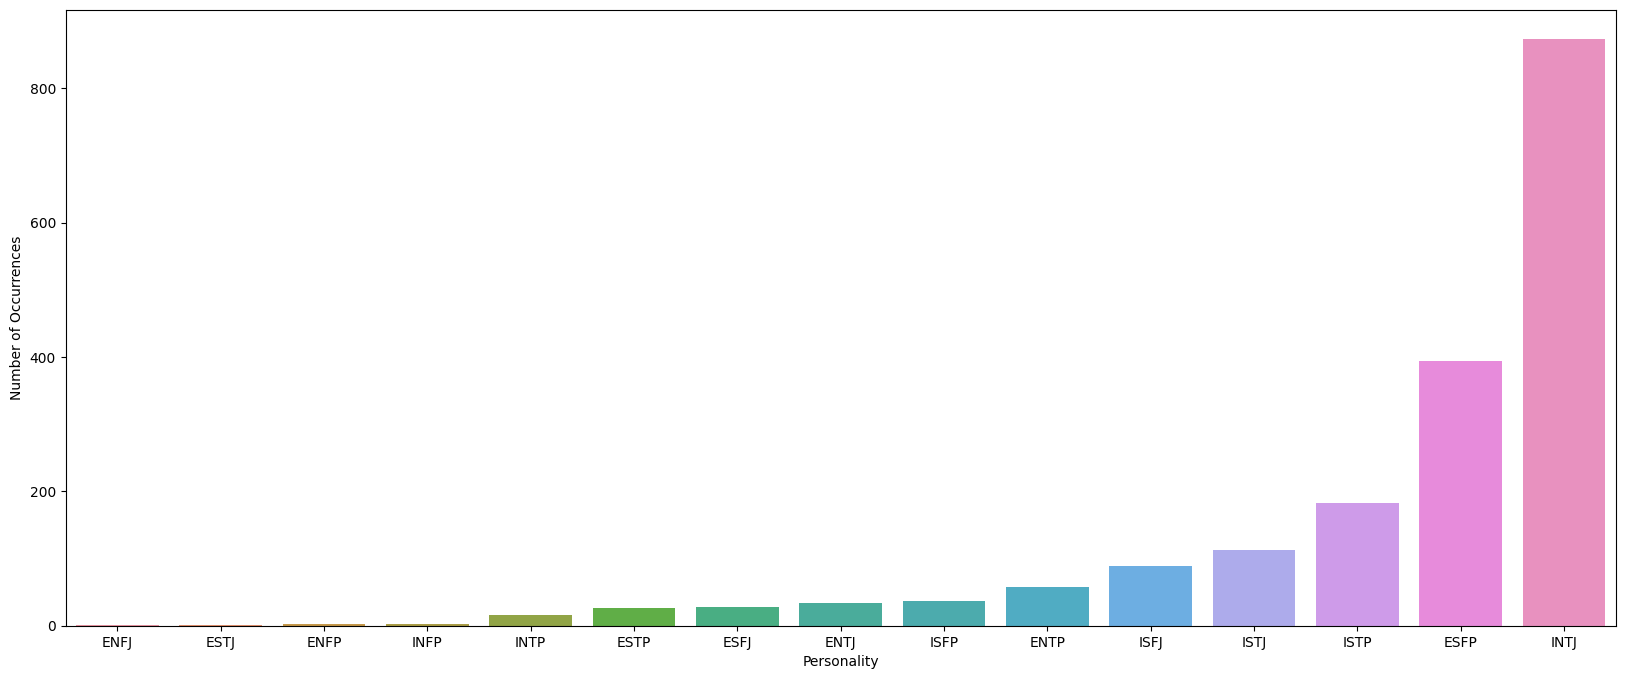

In [62]:
pred_df.sort_values('Count', inplace=True)
plt.figure(figsize=(20,8))
sns.barplot(x=pred_df['Personality'], y=pred_df['Count'])
plt.ylabel('Number of Occurrences')
plt.xlabel('Personality')
plt.show()

#### So from the above bar graph, we can conclude that most Kaggle users have *INTJ (Introversion Intuition Thinking Judging)* type of Personality.